In [323]:
from pathlib import Path
import pandas as pd
import numpy as np
raw_data_path = '2022_hackathon_hemsil2_dataset'
data_dir = Path(raw_data_path)
data_path = data_dir / "hemsil2_datapoints_20102021.csv"
meta_data_path = data_dir / "ts_info.csv"
data_df = pd.read_csv(data_path, sep=',', parse_dates=True, index_col=0)
meta_data_df = pd.read_csv(meta_data_path, sep=',', index_col=0)
meta_data_dict = {record['name']: record for record in meta_data_df.to_dict('records')}
main_df=data_df.copy()
data_df = data_df[data_df.index < pd.Timestamp(year=2021, month=9, day=1)]
data_df = data_df.interpolate(method='linear')

In [324]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [325]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [326]:
def prepare_time_feature(df):
    data_df=df.copy()
    data_df['year']=data_df.index.year
    data_df['month']=data_df.index.month
    data_df['day']=data_df.index.day
    data_df['hour']=data_df.index.hour
    data_df['day_of_year']=data_df.index.day_of_year
    
    return data_df


In [327]:
#To make the dataframe easy to train on the flowrate is shiften 24 hours. So the target is the flowrate in 24 hours
temp=data_df.iloc[24:]['hemsil2_inflow_corr']
data_df.drop(data_df.index[-24:], inplace=True)
data_df['actual_24h']=temp.values

In [328]:
data_df=prepare_time_feature(data_df)

In [329]:
data_df.dropna(inplace=True)
print(data_df.isna().sum().to_string())

flaevatn_ppt                   0
hbv_hemsil2_inflow_pred_24h    0
flaevatn_temp                  0
hbv_hemsil2_snow               0
hemsil2_inflow_corr            0
hbv_hemsil2_ground_water       0
hbv_hemsil2_soil_water         0
hbv_hemsil2_inflow_pred_48h    0
hbv_hemsil2_total_water        0
storeskar_inflow               0
storeskar_temp                 0
hbv_hemsil2_snow_cover         0
actual_24h                     0
year                           0
month                          0
day                            0
hour                           0
day_of_year                    0


In [330]:
#Scaling did not have a positive effect so is not used
# scaler=MinMaxScaler()
# extra_df=scaler.fit_transform(data_df.drop('actual_24h',axis=1).to_numpy())

# extra_df_scaled=pd.DataFrame(extra_df,columns=data_df.columns[data_df.columns!='actual_24h'])

# extra_df_scaled['actual_24h']=data_df.actual_24h.values

# extra_df_scaled['index']=data_df.index
# extra_df_scaled.set_index('index',inplace=True)

In [331]:
#function for outliert thresholds
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.10)
    quartile3 = dataframe[variable].quantile(0.90)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    #print(low_limit, up_limit)
    return low_limit, up_limit

#function that tells if a feature has or not has outliers
def has_outliers(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print("\033[91m {} YES \033[00m".format(variable))
    print(variable, "no")

for col in data_df.columns:
    has_outliers(data_df, col)

 flaevatn_ppt YES 
flaevatn_ppt no
 hbv_hemsil2_inflow_pred_24h YES 
hbv_hemsil2_inflow_pred_24h no
flaevatn_temp no
hbv_hemsil2_snow no
 hemsil2_inflow_corr YES 
hemsil2_inflow_corr no
hbv_hemsil2_ground_water no
 hbv_hemsil2_soil_water YES 
hbv_hemsil2_soil_water no
 hbv_hemsil2_inflow_pred_48h YES 
hbv_hemsil2_inflow_pred_48h no
hbv_hemsil2_total_water no
 storeskar_inflow YES 
storeskar_inflow no
storeskar_temp no
hbv_hemsil2_snow_cover no
 actual_24h YES 
actual_24h no
year no
month no
day no
hour no
day_of_year no


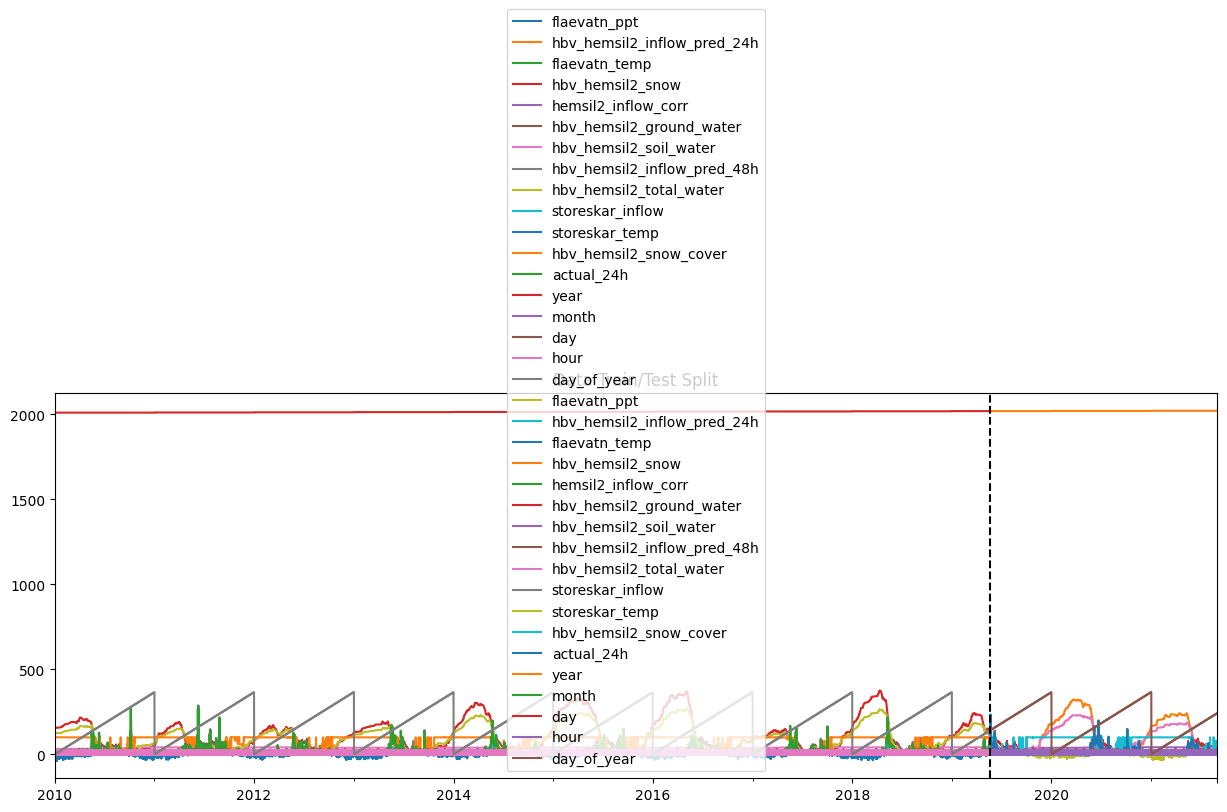

In [332]:
train = data_df.loc[data_df.index < '2019-05-21 16:00:00']
test = data_df.loc[data_df.index >= '2019-05-21 16:00:00']
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2019-05-21 16:00:00', color='black', ls='--')
ax.legend()
plt.show()

In [333]:
data_df.columns

Index(['flaevatn_ppt', 'hbv_hemsil2_inflow_pred_24h', 'flaevatn_temp',
       'hbv_hemsil2_snow', 'hemsil2_inflow_corr', 'hbv_hemsil2_ground_water',
       'hbv_hemsil2_soil_water', 'hbv_hemsil2_inflow_pred_48h',
       'hbv_hemsil2_total_water', 'storeskar_inflow', 'storeskar_temp',
       'hbv_hemsil2_snow_cover', 'actual_24h', 'year', 'month', 'day', 'hour',
       'day_of_year'],
      dtype='object')

In [334]:
#Dropping the HBV model predictions from the trainingset
X_train=train.drop(['hbv_hemsil2_inflow_pred_24h','hbv_hemsil2_inflow_pred_48h','actual_24h','year','hour'],axis=1) 
#To handle the "spiking" problem smoothing is used. The flaevatn_ppt, storeskar_temp and hbv_hemsil2_snow are smoothed as these gave the best result
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
X_train['flaevatn_ppt'] = X_train['flaevatn_ppt'].rolling(window=indexer, min_periods=3).sum()
X_train['storeskar_temp'] = X_train['storeskar_temp'].rolling(window=indexer, min_periods=3).sum()
X_train['hbv_hemsil2_snow'] = X_train['hbv_hemsil2_snow'].rolling(window=indexer, min_periods=3).sum()

#Adding the training target to the model
y_train=train.actual_24h
y_train= y_train.values.reshape(-1,1)

#Dropping the HBV model from the test set
X_test=test.drop(['hbv_hemsil2_inflow_pred_24h', 'hbv_hemsil2_inflow_pred_48h','actual_24h','year','hour'],axis=1)
y_test=test.actual_24h
y_test= y_test.values.reshape(-1,1)


In [335]:
#Run to see info about the training and testing set
X_train.info(),X_test.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82264 entries, 2010-01-01 00:00:00 to 2019-05-21 15:00:00
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   flaevatn_ppt              82262 non-null  float64
 1   flaevatn_temp             82264 non-null  float64
 2   hbv_hemsil2_snow          82262 non-null  float64
 3   hemsil2_inflow_corr       82264 non-null  float64
 4   hbv_hemsil2_ground_water  82264 non-null  float64
 5   hbv_hemsil2_soil_water    82264 non-null  float64
 6   hbv_hemsil2_total_water   82264 non-null  float64
 7   storeskar_inflow          82264 non-null  float64
 8   storeskar_temp            82262 non-null  float64
 9   hbv_hemsil2_snow_cover    82264 non-null  float64
 10  month                     82264 non-null  int64  
 11  day                       82264 non-null  int64  
 12  day_of_year               82264 non-null  int64  
dtypes: float64(10), int64(3)
m

(None, None)

In [336]:
#The prediction model, based on the XGBRegressor
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=2,
                       learning_rate=.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:26.78237	validation_1-rmse:28.15491
[100]	validation_0-rmse:13.85476	validation_1-rmse:14.18314
[200]	validation_0-rmse:10.16366	validation_1-rmse:11.01201
[300]	validation_0-rmse:8.90574	validation_1-rmse:10.30423
[400]	validation_0-rmse:8.35581	validation_1-rmse:10.09018
[500]	validation_0-rmse:8.07126	validation_1-rmse:9.99293
[600]	validation_0-rmse:7.90550	validation_1-rmse:9.93266
[700]	validation_0-rmse:7.80233	validation_1-rmse:9.90652
[800]	validation_0-rmse:7.71320	validation_1-rmse:9.88246
[900]	validation_0-rmse:7.64220	validation_1-rmse:9.86856
[960]	validation_0-rmse:7.60020	validation_1-rmse:9.86904


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [337]:
#Predicting on the test data and gathering the relevant actual values and predicted by HBV model values 
x=reg.predict(X_test)
actual=data_df.loc[data_df.index>=test.index[0]]['hemsil2_inflow_corr']
c_24h=data_df.loc[data_df.index>=test.index[0]]['hbv_hemsil2_inflow_pred_24h']



[]

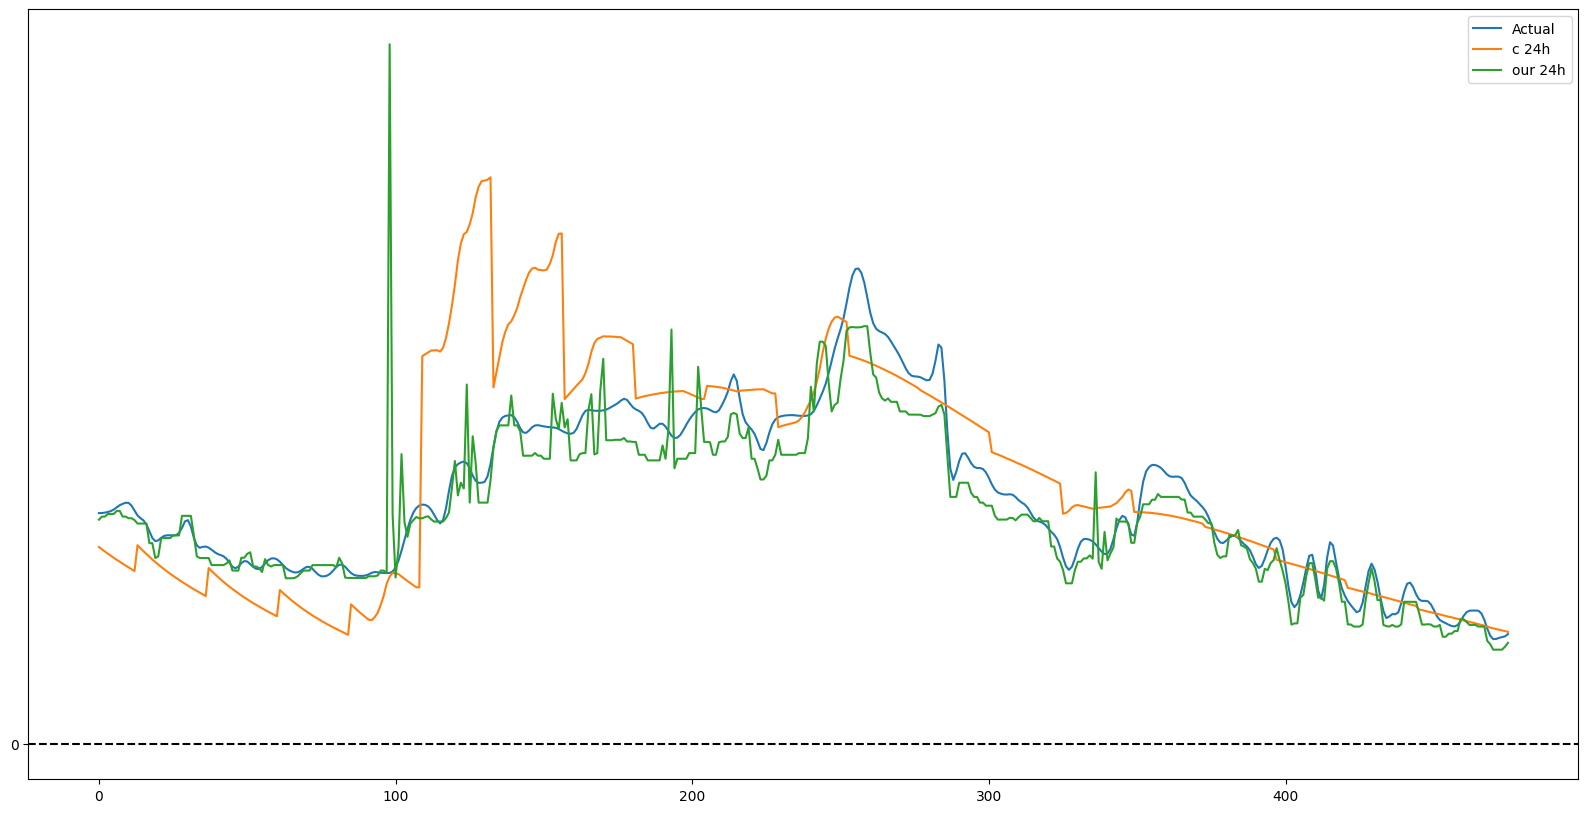

In [338]:
# Pretty plots
fig=plt.figure(figsize=(20,10))
i=18500
j=-1000
xx=actual[i:j]
yy=c_24h.values[i:j]
zz=x[i:j]
plt.plot(range(len(xx)),xx,label='Actual')
plt.plot(range(len(yy)),yy,label='c 24h')
plt.plot(range(len(zz)),zz,label='our 24h')
plt.axhline('0', color='black', ls='--')
plt.legend()
plt.plot()

[]

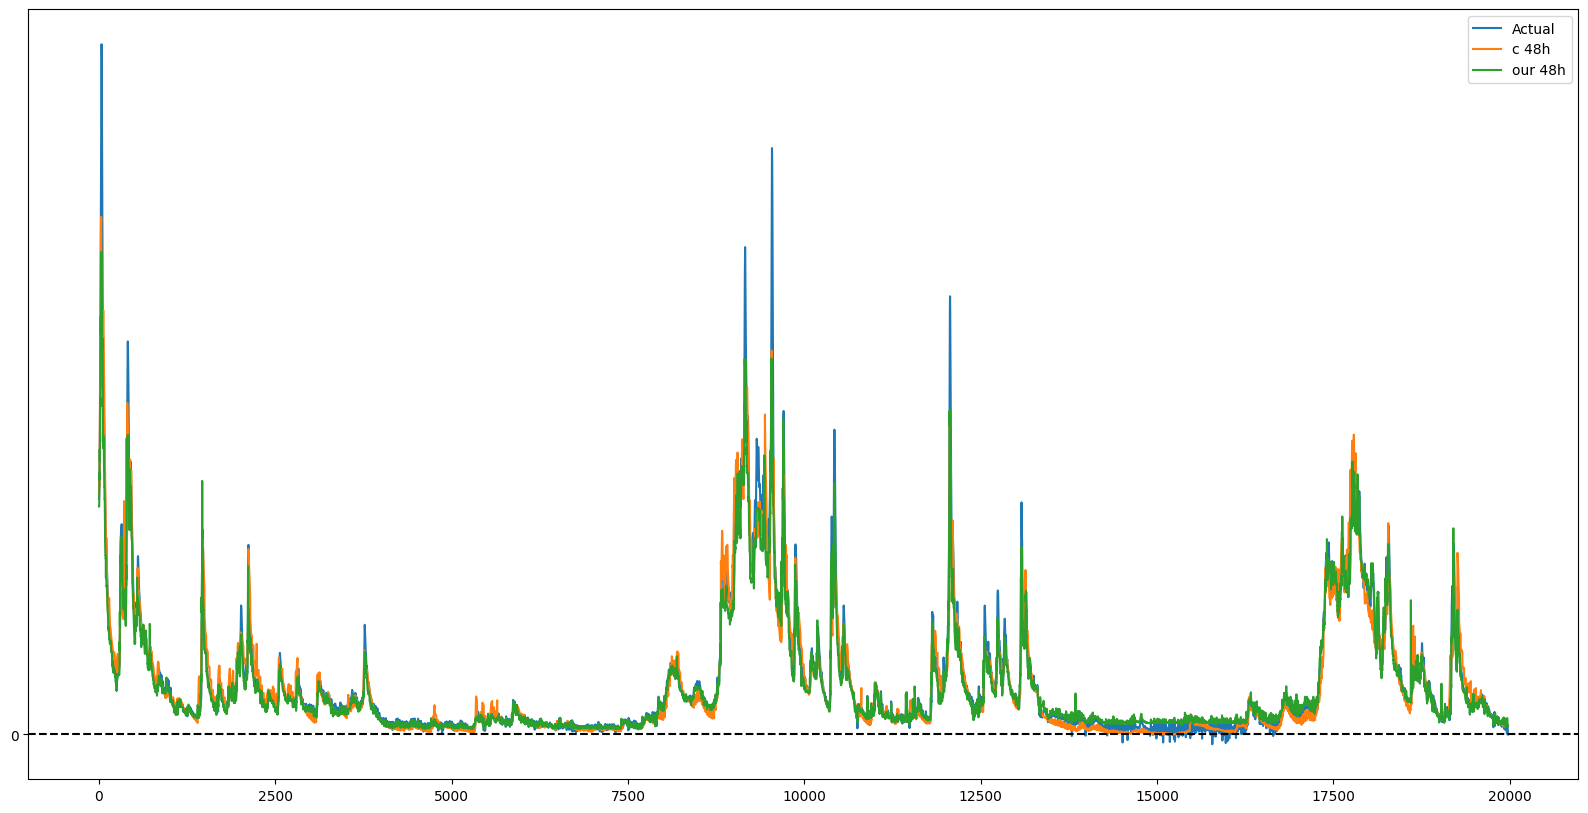

In [339]:
#more pretty plots
fig=plt.figure(figsize=(20,10))

xx=actual
yy=c_24h.values
zz=x
plt.plot(range(len(xx)),xx,label='Actual')
plt.plot(range(len(yy)),yy,label='c 48h')
plt.plot(range(len(zz)),zz,label='our 48h')
plt.axhline('0', color='black', ls='--')
plt.legend()
plt.plot()

In [340]:
len(x),len(c_24h),len(actual)

(19976, 19976, 19976)

In [341]:
#Checking the difference between regression model and the HBV model
mean_absolute_error(c_24h,x), mean_squared_error(c_24h, x)

(3.463681124813279, 30.236529832816476)

In [342]:
#Calculating final error for regression model
mean_absolute_error(actual,x), mean_squared_error(actual, x)

(2.312275609747381, 26.653018631899396)

In [343]:
#Calculating error for HBV model

mean_absolute_error(actual,c_24h), mean_squared_error(actual, c_24h)

(3.2182213656387666, 40.48488169303164)

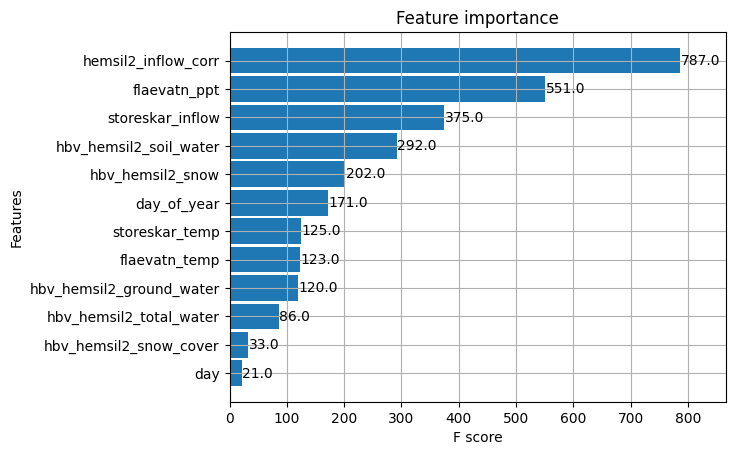

In [344]:
_ = plot_importance(reg, height=0.9)

In [345]:
mean_absolute_error(test.hemsil2_inflow_corr,test.hbv_hemsil2_inflow_pred_24h)

3.2182213656387666